# Estudio de baterías y paneles

## Import de las librerías necesarias

In [1]:
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd
import seaborn as sns

## Datos de consumo

In [2]:
#Lectura del archivo
df = pd.read_csv('household_power_consumption.txt', sep=';',
                 parse_dates={'Fecha' : ['Date', 'Time']},
                 infer_datetime_format=True, 
                 low_memory=False,
                 na_values=['nan','?'],
                 index_col='Fecha')

In [3]:
df=df['Global_active_power'].resample('h').mean()

In [4]:
consumo_horas_dia = df.groupby(df.index.hour).mean()

In [5]:
hours=df.index.hour

In [6]:
consumo_plot=pd.concat([df, pd.DataFrame(hours, index=df.index)], axis = 1)

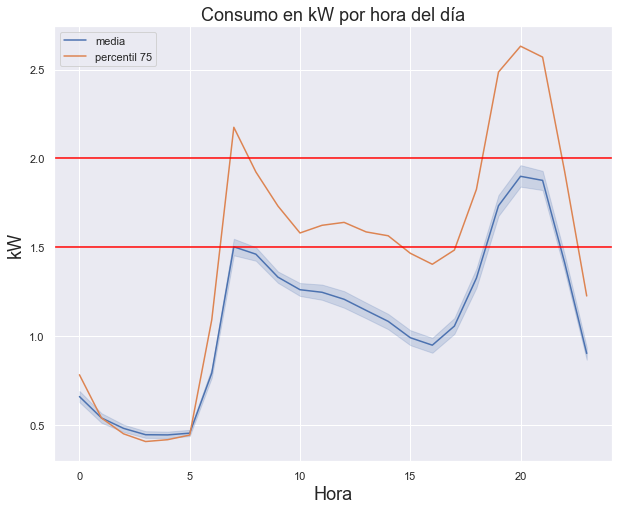

In [7]:
plt.figure(figsize = (10,8))
sns.set_theme(style='darkgrid')
plt.title('Consumo en kW por hora del día', fontsize=18)
plt.xlabel('Hora', fontsize=18)
plt.ylabel('kW', fontsize=18)


graph = sns.lineplot(x='Fecha', y='Global_active_power', data=consumo_plot, label='media')
graph = sns.lineplot(data=df.groupby(df.index.hour).quantile(0.75), label='percentil 75')
graph.axhline(2, color='red')
graph.axhline(1.5, color='red')

# Datos de generación

In [8]:
#Lectura del archivo

string = '%Y%m%d:%H%M'

rad = pd.read_csv('radiationdata.csv', sep=',',
                 parse_dates={'Fecha' : ['time']},
                 infer_datetime_format=True, 
                 low_memory=False,
                 na_values=['nan','?'],
                 index_col='Fecha')

In [9]:
string = '%Y%m%d:%H%M'
rad.index = pd.to_datetime(rad.index, format=string)
rad['hour'] = rad.index.hour

In [10]:
rad=rad[['G(i)','hour']]

<AxesSubplot:title={'center':'Irradiancia diaria, año típico (PVGIS)'}, xlabel='Hora del día', ylabel='G(i), W/m2'>

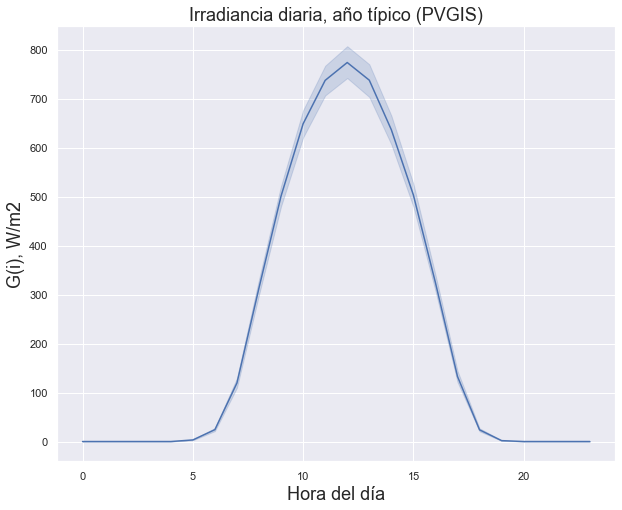

In [11]:
plt.figure(figsize = (10,8))
sns.set_theme(style='darkgrid')
plt.title('Irradiancia diaria, año típico (PVGIS)', fontsize=18)
plt.xlabel('Hora del día', fontsize=18)
plt.ylabel('G(i), W/m2', fontsize=18)
sns.lineplot(x='hour', y='G(i)', data=rad)

### Datos de potencia generada

In [12]:
rendimiento = 0.15
superficie = 17

rad['potencia'] = (rad['G(i)'] * rendimiento * superficie)/1000

In [13]:
rad.describe()

,G(i),hour,potencia
count,8784.000000,8784.000000,8784.000000
mean,228.423913,11.500000,0.582481
std,331.098905,6.922581,0.844302
min,0.000000,0.000000,0.000000
25%,0.000000,5.750000,0.000000
50%,0.000000,11.500000,0.000000
75%,432.872500,17.250000,1.103825
max,1436.630000,23.000000,3.663407


# Generación vs consumo

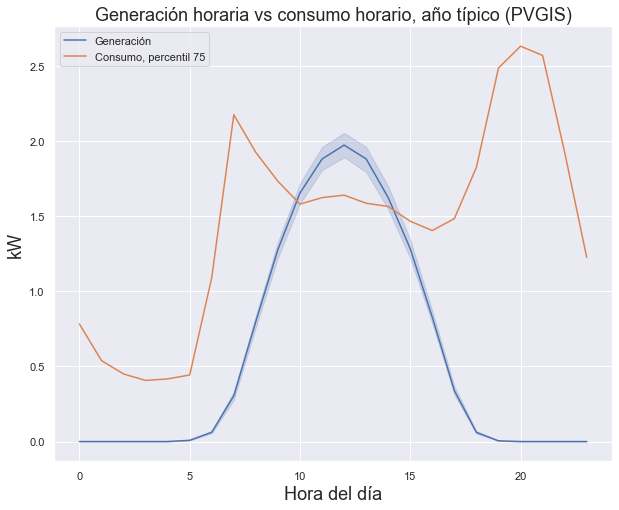

In [14]:
plt.figure(figsize = (10,8))
sns.set_theme(style='darkgrid')
plt.title('Generación horaria vs consumo horario, año típico (PVGIS)', fontsize=18)
plt.xlabel('Hora del día', fontsize=18)
plt.ylabel('kW', fontsize=18)
sns.lineplot(x='hour', y='potencia', data=rad, label='Generación')

#graph = sns.lineplot(x='Fecha', y='Global_active_power', data=consumo_plot, label='media')
graph = sns.lineplot(data=df.groupby(df.index.hour).quantile(0.75), label='Consumo, percentil 75')

## Baterias

In [15]:
total_consumo_dia = df.groupby(df.index.hour).mean()

In [16]:
potencia_diaria = rad['potencia'].groupby(rad.index.hour).mean()
consumo_diario = df.groupby(df.index.hour).quantile(0.75) 

In [17]:
diff = potencia_diaria - consumo_diario

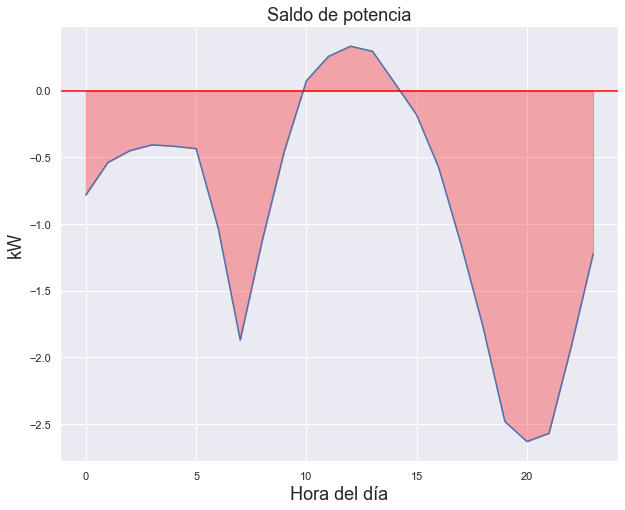

In [20]:
plt.figure(figsize = (10,8))
sns.set_theme(style='darkgrid')

plt.title('Saldo de potencia', fontsize=18)
plt.xlabel('Hora del día', fontsize=18)
plt.ylabel('kW', fontsize=18)
ax = sns.lineplot(data=diff)
l1 = ax.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

ax.fill_between(x1, y1, color="red", alpha=0.3)
ax.axhline(0, color='red')

In [59]:
start_valle = 0
end_valle = 8
index = list(range(start_valle+1,end_valle+1))

day_diff = diff[diff.index.difference(index)]
day_diff

Fecha
0    -0.782217
9    -0.453693
10    0.074019
11    0.256911
12    0.333388
13    0.295071
14    0.058772
15   -0.182795
16   -0.577356
17   -1.145550
18   -1.765000
19   -2.481072
20   -2.631333
21   -2.569842
22   -1.925783
23   -1.225742
dtype: float64

In [90]:
reindex = day_diff.index[1:].to_list()
reindex.append(day_diff.index[0])
day_diff_re = day_diff.reindex(reindex)
day_diff_re.index.values[-1] = 24
day_diff_re

Fecha
9    -0.453693
10    0.074019
11    0.256911
12    0.333388
13    0.295071
14    0.058772
15   -0.182795
16   -0.577356
17   -1.145550
18   -1.765000
19   -2.481072
20   -2.631333
21   -2.569842
22   -1.925783
23   -1.225742
24   -0.782217
dtype: float64

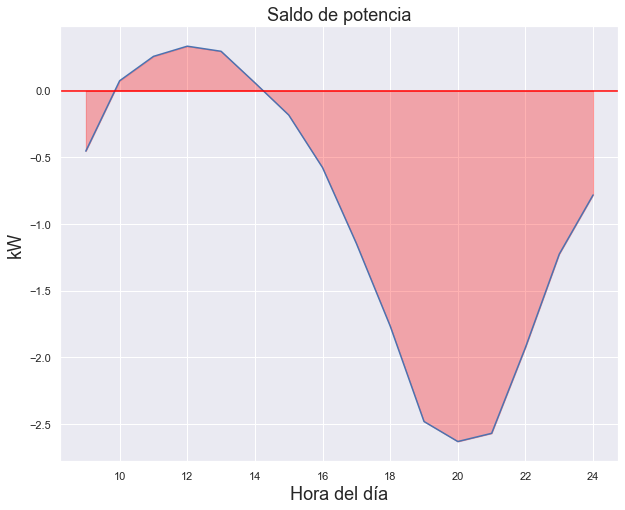

In [67]:
plt.figure(figsize = (10,8))
sns.set_theme(style='darkgrid')

plt.title('Saldo de potencia', fontsize=18)
plt.xlabel('Hora del día', fontsize=18)
plt.ylabel('kW', fontsize=18)
ax = sns.lineplot(data=day_diff_re)
l1 = ax.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

ax.fill_between(x1, y1, color="red", alpha=0.3)
ax.axhline(0, color='red')

In [78]:
capacidad=day_diff_re.sum()
print(capacidad)

-14.722222377049185


In [94]:
day_diff_re

Fecha
9    -0.453693
10    0.074019
11    0.256911
12    0.333388
13    0.295071
14    0.058772
15   -0.182795
16   -0.577356
17   -1.145550
18   -1.765000
19   -2.481072
20   -2.631333
21   -2.569842
22   -1.925783
23   -1.225742
24   -0.782217
dtype: float64

In [144]:
energy = []
last_value = 0
values = []
for x in day_diff_re:
    value=x+last_value
    energy.append(value)
    last_value = value
print(energy[-1])
print(capacidad)

-14.722222377049183
-14.722222377049185


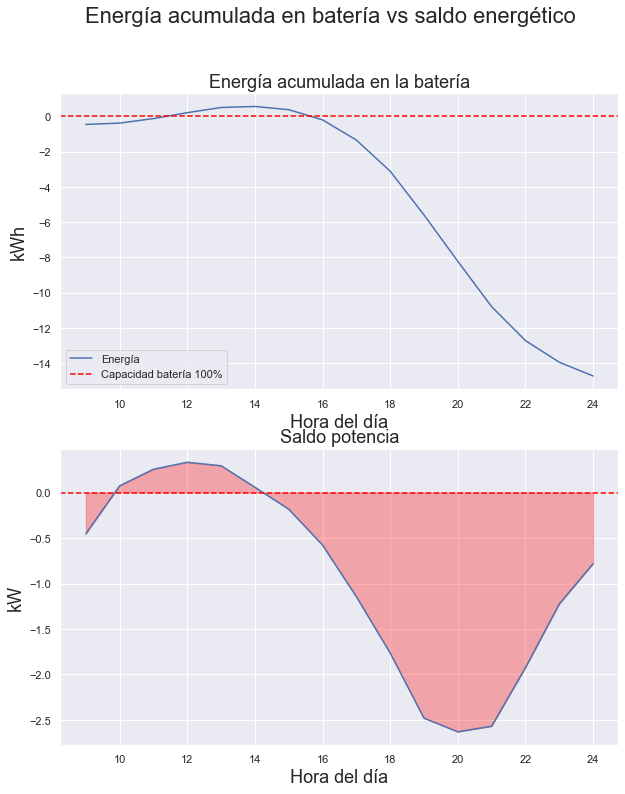

In [145]:
fig, axes = plt.subplots(2, figsize=(10, 12), sharey=False)
fig.suptitle('Energía acumulada en batería vs saldo energético', fontsize=22)

# Energia en bateria
sns.lineplot(ax=axes[0],y=energy, x=day_diff_re.index, label='Energía')
axes[0].set_title('Energía acumulada en la batería', fontsize=18)
axes[0].set_xlabel('Hora del día', fontsize=18)
axes[0].set_ylabel('kWh', fontsize=18)
axes[0].axhline(0, color='red', ls='--', label='Capacidad batería 100%')
axes[0].legend()

# Saldo de potencia
sns.lineplot(ax=axes[1], data=day_diff_re)
axes[1].set_title('Saldo potencia', fontsize=18)
axes[1].set_xlabel('Hora del día', fontsize=18)
axes[1].set_ylabel('kW', fontsize=18)


l1 = axes[1].lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

axes[1].fill_between(x1, y1, color="red", alpha=0.3)
axes[1].axhline(0, color='red',ls='--')

In [149]:
max(energy)

0.5644676038251333